## CS224 - Winter 2024
## HW 3: Dog Denoiser

Submit **PDF** of completed IPython notebook on **Canvas**

**Due**: March 12, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Joseph Mangapit
  </br>

  <b>Student ID Number</b>:  862175676
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment, we will make a linear and nonlinear dog denoiser (inspired by the need to restore a damaged image of Sir Fluffles III to its former glory as discussed in class).
Complete all the code marked `TODO`.

### Import libraries, data, viz data
This section can remain unchanged.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/CS224

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/CS224')

Using device: cuda
Example images of CIFAR-10 dogs


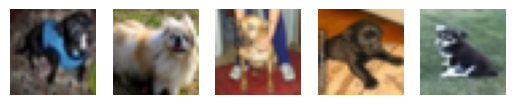

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet

def show_image(xs):
    """Display a list of CIFAR-10 images in a table.
    Images may be flattened or unflattened.
    Assumes floats in range [0,1] representing colors"""
    xs = xs.cpu()
    n = len(xs)
    fig, axs = plt.subplots(1, n)
    for i, ax in enumerate(axs):
        x = xs[i].reshape(3, 32, 32).moveaxis(0, -1)
        x = torch.clamp(x, 0., 1.)
        ax.imshow(x)
        ax.axis('off')
    return fig

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# datasets are small enough to be loaded on GPU
# usually we leave on CPU and only put the training batch on GPU
dogs_train, dogs_val = torch.load('/content/drive/MyDrive/CS224/hw3_data.pt', map_location=device)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)

def test_model(model, val_loader=val_loader):
    """Code to test MSE on validation data."""
    criterion = nn.MSELoss()
    model.eval()
    mse = 0.
    with torch.no_grad():
        for x, in val_loader:
            x_noise = x + 0.1 * torch.randn_like(x)
            x_hat = model(x_noise).view(x.shape)
            mse += criterion(x, x_hat) / len(val_loader)
    return mse

print("Example images of CIFAR-10 dogs")
fig = show_image(dogs_train[:5])

In [4]:
class LinearDenoiser(nn.Module):
    """Denoise by projecting onto linear subspace spanned by
    top principal components."""
    def __init__(self, d=500):
        super(LinearDenoiser, self).__init__()
        self.d = d  # Number of principal components to use
        # We won't use backprop on this model,
        # so you can initialize/store parameters however you like
        self.mean = None
        self.U = None
        self.S = None
        self.U_copy = None



    def forward(self, x):
        x = x.flatten(start_dim=1)  # Flatten images to vectors
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

    def encode(self, x):
        # TODO [1 points]: encode x into low-d latent space
        x = x.flatten(start_dim=1)
        self.mean = x.mean(dim=0)

        x = (x - self.mean)
        z = torch.mm(x, self.U[:, :self.d])
        return z

    def decode(self, z):
        x_hat = torch.mm(z, self.U[:, :self.d].t()) + self.mean
        # TODO [1 points]: linearly decode back to x-space
        return x_hat

    def fit(self, x):
        x = x.flatten(start_dim=1)
        self.mean = x.mean(dim=0)
        n = len(x)
        x = (x - self.mean)
        cov_matrix = torch.mm(x.t(), x) / n
        self.U, self.S, self.U_copy = torch.svd(cov_matrix)
        #z = self.encode(x)
        #x_hat = self.decode(z)
        #x = x_hat
        #return x_hat
        # TODO [4 points]: Use PCA to get the parameters
        # Don't forget to center the data and store mean
        # for reconstruction.
        # Use SVD to get eigenvectors of covariance,
        # like I did in class

linear_model = LinearDenoiser()
#dogs_train = dogs_train.flatten(start_dim=1)
#mean = dogs_train.mean(dim=0)
#n = len(dogs_train)  # number of images
#dog_images = (dogs_train - mean)
#fig1 = show_image(dogs_train[:10])
linear_model.fit(dogs_train)

#fig2 = show_image(dogs_train[:10])
#display(fig2)

### Train U-Net [5 points]
Use the included U-Net, and train it to denoise images
by minimizing the Mean Square Error loss (nn.MSELoss) between images and reconstructions from a noisy version of the image.
Use a noise standard deviation of 0.1.
Train with SGD.

In [5]:
train_loader = DataLoader(TensorDataset(dogs_train), batch_size=50, drop_last=True)

In [7]:
# TODO [5 points]
# Train the UNet.
# This one is a little slow to train.
# I got reasonable results in 20 epochs on my laptop, in about 30 mins
# However, you might want to learn how to use cuda() on colab
# to dramatically speed this up.
#dogs_train= dogs_train.flatten(start_dim=1)
model = UNet()
criterion = nn.MSELoss()
model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.1)
num_epochs = 20
total_loss = 0.0
mean = dogs_train.mean(dim=0)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, in train_loader: #got help to use the data loader by not putting a second input in the for loop

      #print(epoch)

      #print(x_batch.shape)
      #inputs, labels = x_batch
      #print(inputs.shape, labels.shape)
      model.zero_grad()
      #print("help")
      #x_noise = dogs_train + 0.1 * torch.rand_like(dogs_train)
      out = model(inputs)
      loss = criterion(out, inputs)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #loss = criterion(logits, x_batch)
      #loss.backward()
      #optimizer.step()

model.eval()
print(total_loss)
#    total_loss = 0.0
#
#    for inputs, labels in train_loader:
#        print("hello")


0.0


###  Results [4 points]

You shouldn't need to change the code below. It just prints out denoised images and validation loss using your trained UNet and fitted Linear model.

4 points for getting correct looking results. It should be possible to get MSE below 0.01 (value for no denoising at all), and the denoised images should be noticeably better, for linear and nonlinear denoisers

Original images


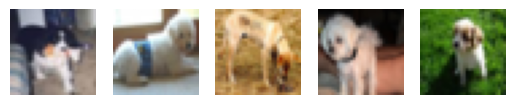

Noisy images


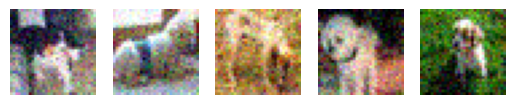

Linear denoising


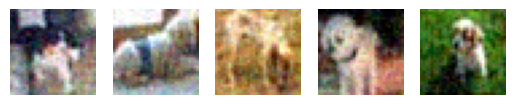

UNet denoising


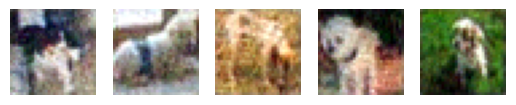

Linear model Val MSE: 0.0028
UNet Val MSE: 0.0040


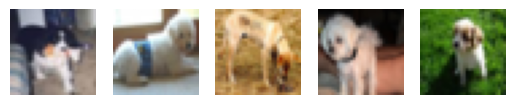

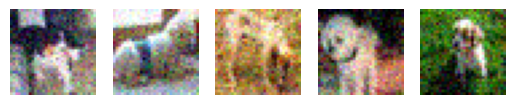

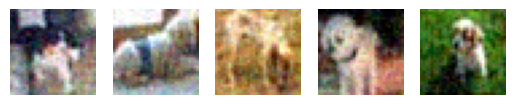

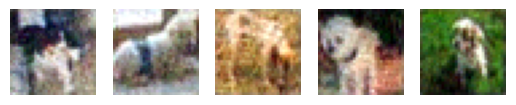

In [8]:
dogs = dogs_val[:5].cpu()
noisy_dogs = dogs + 0.1 * torch.randn_like(dogs)  # Done on CPU to avoid MPS bug!
with torch.no_grad():
    linear_denoise = linear_model(noisy_dogs.to(device)).cpu()
    unet_denoise = model(noisy_dogs.to(device)).cpu()

print("Original images")
display(show_image(dogs))
print("Noisy images")
display(show_image(noisy_dogs))
print("Linear denoising")
display(show_image(linear_denoise))
print("UNet denoising")
display(show_image(unet_denoise))

linear_mse = test_model(linear_model)
unet_mse = test_model(model)
print(f"Linear model Val MSE: {linear_mse:.4f}")
print(f"UNet Val MSE: {unet_mse:.4f}")

###  Extra credit
We won't have time for grading since we're near the end of class, so no extra credit opportunities.
There are some interesting things to explore though. What happens if you put an already denoised image through the denoiser again? If you keep repeating, will it converge to some fixed point? What happens if you put some images that differ significantly from training? For instance, will noisy cats get turned into dogs? If we put pure Gaussian noise in, will we eventually get something dog-like?
